In [1]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [2]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/1445812906.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


# import data directly from google sheets

In [3]:
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1bfPrp0w8Ruorq08Qe4hD8M3xVJ5e00phZ6ApFivO98k') # dec 2022 version

#spreadsheet[1] "oil Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([gas_pipes, oil_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [4]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [5]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [6]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [7]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [8]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [9]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# projects by country, by region

In [10]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_country_df[status] = country_ratios_oil_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


# numbers of pipes finished in a given year

In [11]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Oil')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [12]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Oil')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [13]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Oil')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [14]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Oil') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [15]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Oil')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [16]:
pipes_indev_startyear.unstack()

StartYearEarliest,2021.0,2022.0,2023.0,2024.0,2025.0,2026.0,2027.0,2028.0,2030.0,NaN
Status,,,,,,,,,,
Construction,NaN,NaN,2601.10,3730.0,216.78,NaN,NaN,NaN,NaN,2583.00
Proposed,NaN,3414.07,1235.56,2403.5,2717.13,1400.0,728.0,NaN,20.0,10010.66
Shelved,1234.36,NaN,536.00,NaN,NaN,NaN,NaN,1562.0,4800.0,2812.60


In [17]:
pipes_indev_startyear['Construction',2023]

2601.1

## Fig 2 - 2023–2030, go back to 2008

## future/past plot

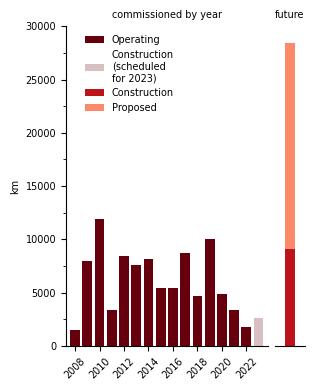

In [18]:
font_size = 7

ytop = 30000
ytop2 = 30000
xlo = 2008
xhi = 2023

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.loc[range(xlo,xhi+1)].index.values, pipes_started_sum.loc[range(xlo,xhi+1)].values,
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2023,pipes_indev_startyear['Construction',2023],
       label='Construction\n(scheduled\nfor 2023)', bottom=pipes_started_sum.loc[2023], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(xlo-0.75, xhi+0.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []


ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2023],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0.5)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022-alt.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008-with-2022-alt.pdf', bbox_inches='tight', transparent=True)

In [19]:
pipes_indev

Status
Construction     9130.88
Proposed        21928.92
Shelved         10944.96
Name: LengthMergedKm, dtype: float64

## percent pipelines with start date (sanity check)

In [20]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Oil') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [21]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.5185185185185185

## regional pipelines started in given year

In [22]:
pipes_df_orig['StartYearEarliest'].min()

1904.0

In [23]:
years_array = numpy.arange(float(pipes_df_orig['StartYearEarliest'].min()), 
                           float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [24]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='oil']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='oil')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [25]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

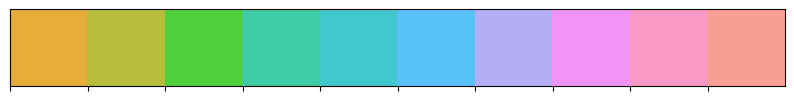

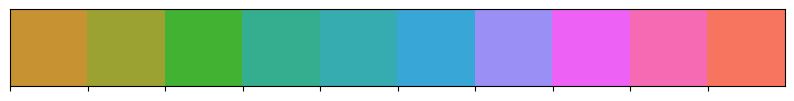

In [26]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

# top 20 countries proposed+construction

In [27]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

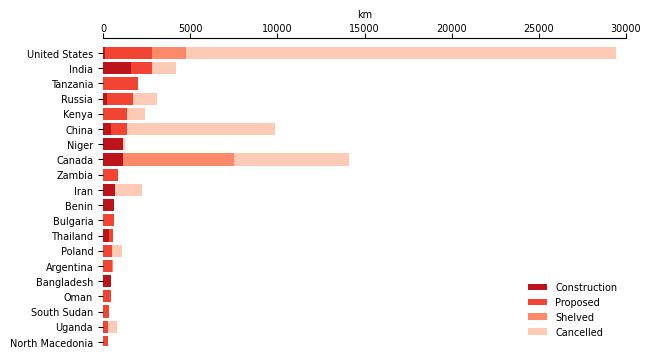

In [28]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/2799680308.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sel_cmap = matplotlib.cm.get_cmap('Reds')


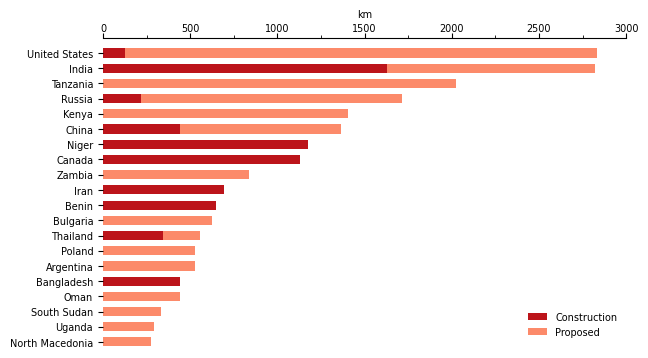

In [29]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,3000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [30]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

0.4842103399433427

# parent analysis

## print out leading parent companies

### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [31]:
# kuhne paper, for oil
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [32]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
East Asia                          18
Eurasia                             2
Europe                              8
Latin America and the Caribbean     2
Middle East and North Africa       18
North America                      21
SE Asia                             2
South Asia                          2
Sub-Saharan Africa                  6
Name: CapacityBOEd, dtype: int64

fraction

In [33]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
SE Asia,1.000
Sub-Saharan Africa,1.000
North America,0.808
Europe,0.800
Latin America and the Caribbean,0.667
East Asia,0.643
Middle East and North Africa,0.600
South Asia,0.400
Eurasia,0.222


In [34]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y'].median()

In [35]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil']['CapacityBcm/y'].median()).median()

In [36]:
pipes_df_orig['CapacityBcm/y'].mean()

275.13983333333334

In [37]:
pipes_df_orig['CapacityBcm/y'].std()

661.9561514922354

In [38]:
print(median_capacity)
print(abs_dist_from_med_capacity)

475.26
316.84000000000003


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

## pick out high and low quantiles

In [39]:
temp_df = pipes_df_orig.loc[(~pipes_df_orig.CostUSDPerKm.isnull())&
                            (pipes_df_orig.Fuel=='Oil')]
qlo_val = 0.025
qhi_val = 0.975

q_lo=temp_df['CostUSDPerKm'].quantile(qlo_val)
q_hi=temp_df['CostUSDPerKm'].quantile(qhi_val)
print(temp_df['CostUSDPerKm'].quantile(qlo_val))
print(temp_df['CostUSDPerKm'].quantile(qhi_val))

temp_df = temp_df.loc[temp_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]

67935.41416150001
16097583.484999996


In [40]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.loc[(country_ratios_df['Fuel']=='Oil') & 
                                                               (country_ratios_df['CostUSDPerKm'].notna()) & 
                                                               (country_ratios_df['LengthKnownKmByCountry'].notna()) #&
                                                               #(country_ratios_df['LengthKnownKm']!=0) &
                                                               #(country_ratios_df['CostUSDPerKm']<10e6)
                                                              ]

country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df.loc[
    country_ratios_with_length_and_cost_df['CostUSDPerKm'].between(q_lo, q_hi, inclusive='neither')]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [41]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

2627225.888863636

### calculate regional costs

In [42]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_oil_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()


Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


In [43]:
country_ratios_region_df['CostUSDPerKm'].mean()

4534482.848888889

In [44]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_oil_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,4.534,4
North America,3.189,31
Middle East and North Africa,2.721,17
Europe,2.702,7
South Asia,2.431,3
Eurasia,2.288,7
East Asia,2.231,7
Latin America and the Caribbean,1.341,6
Australia and New Zealand,1.214,6
SE Asia,0.939,6


### calculate country-level costs

# tables etc.

## table for regional totals

In [45]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/997741405.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Sub-Saharan Africa,"4,888.750","1,950.000","6,838.750",986.170,"2,100.000","8,932.050",0.000,0.000,0.000
North America,"2,705.360","1,258.700","3,964.060","8,264.230","31,342.880","107,839.430",0.000,0.000,"6,453.810"
South Asia,"1,206.470","2,070.000","3,276.470",0.000,"1,691.000","9,982.960",0.000,0.000,0.000
Europe,"1,991.040",207.000,"2,198.040",0.000,"6,224.930","25,470.300",394.680,0.000,0.000
Eurasia,"1,494.200",220.180,"1,714.380",95.000,"3,501.490","46,917.990",837.060,932.180,862.000
Middle East and North Africa,788.000,793.000,"1,581.000",536.000,"3,586.770","25,859.720",0.000,"2,368.080","1,785.500"
East Asia,927.410,440.000,"1,367.410",0.000,"8,480.640","24,609.210",46.350,0.000,"7,365.150"
SE Asia,228.020,342.000,570.020,0.000,306.000,"2,526.270",0.000,0.000,0.000
Latin America and the Caribbean,525.000,0.000,525.000,55.000,"3,937.830","12,075.320",0.000,425.000,0.000
Australia and New Zealand,0.000,0.000,0.000,0.000,0.000,"1,720.300",0.000,0.000,187.000


## table for km by country

In [46]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/oil-pipelines-km-by-country.xlsx')

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/1092591467.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [75]:
pipes_oil_costs_region_df.sort_values('CostUSDPerKm', ascending=False)

,CostUSDPerKm,DataPoints
Sub-Saharan Africa,"4,534,482.8",4
North America,"3,188,542.7",31
Middle East and North Africa,"2,721,339.3",17
Europe,"2,701,820.9",7
South Asia,"2,430,679.7",3
Eurasia,"2,288,045.5",7
East Asia,"2,230,980.2",7
Latin America and the Caribbean,"1,341,174.6",6
Australia and New Zealand,"1,213,941.7",6
SE Asia,"938,922.1",6


In [48]:
country_ratios_oil_df.reset_index(drop=True, inplace=True)
country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_oil_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_oil_df.loc[idx,'CostUSDEstimate'] = pipes_oil_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_oil_df.loc[(~country_ratios_oil_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_oil_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/1135204043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_oil_df.loc[:,'CostUSDEstimate'] = numpy.nan


In [49]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df.Status==status]
    capex_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [50]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [51]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [52]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/2444263024.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_region_df = capex_by_region_df.append(total)


In [53]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

/var/folders/fl/t07mc8053p33mn6mdmvp45580000gn/T/ipykernel_65964/3950818690.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_country_df = capex_by_country_df.append(total)


In [54]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,8.9,17.9,26.8,34.2,86.8,333.0,0.0,0.0,20.6
Sub-Saharan Africa,12.8,7.0,19.8,0.0,9.5,31.3,0.0,0.0,0.0
Europe,10.7,0.1,10.8,0.0,8.2,65.5,0.3,0.0,0.0
Middle East and North Africa,5.2,2.0,7.2,1.5,5.5,62.3,0.0,4.4,4.9
South Asia,1.2,5.4,6.5,0.0,4.1,21.4,0.0,0.0,0.0
Eurasia,3.4,0.3,3.7,0.2,7.6,103.6,1.9,2.1,2.0
East Asia,2.0,0.8,2.9,0.0,14.4,51.9,0.1,0.0,12.4
SE Asia,0.0,0.3,0.3,0.0,0.4,2.4,0.0,0.0,0.0
Latin America and the Caribbean,0.1,0.0,0.1,0.1,8.0,16.8,0.0,0.2,0.0
Australia and New Zealand,0.0,0.0,0.0,0.0,0.0,1.9,0.0,0.0,0.2


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [74]:
country_sums_USDBillion_df.replace(numpy.nan, 0).sort_values('CostUSDEstimate', ascending=False)

,CostUSDEstimate
Country,
Canada,17.5
United States,9.3
Tanzania,8.0
Poland,5.3
India,5.1
Niger,4.2
Zambia,3.8
Russia,3.7
China,2.9


In [56]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['Canada','United States','Tanzania','Poland','India']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['Proposed+Construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')
    print(country_ratios_oil_df.loc[(country_ratios_oil_df.Country==cntry)&
                          (country_ratios_oil_df.Status=='Construction')]['CostUSDEstimate'].sum()/1e9, 'construction capex')
    print(country_ratios_oil_df.loc[(country_ratios_oil_df.Country==cntry)&
                          (country_ratios_oil_df.Status=='Proposed')]['CostUSDEstimate'].sum()/1e9, 'proposed capex')
    print()

Canada
0.0  km proposed
1130.0  km in construction
1130.0  total km in development
CostUSDEstimate   17.5
Name: Canada, dtype: float64 USD
17.520000005300002 construction capex
0.0 proposed capex

United States
2705.36  km proposed
128.7  km in construction
2834.06  total km in development
CostUSDEstimate   9.3
Name: United States, dtype: float64 USD
0.4103654450357647 construction capex
8.865238180689907 proposed capex

Tanzania
2025.37  km proposed
0.0  km in construction
2025.37  total km in development
CostUSDEstimate   8.0
Name: Tanzania, dtype: float64 USD
0.0 construction capex
7.9501763653557775 proposed capex

Poland
529.53  km proposed
0.0  km in construction
529.53  total km in development
CostUSDEstimate   5.3
Name: Poland, dtype: float64 USD
0.0 construction capex
5.261619117168911 proposed capex

India
1194.0  km proposed
1630.0  km in construction
2824.0  total km in development
CostUSDEstimate   5.1
Name: India, dtype: float64 USD
3.9620078403666668 construction capex
1

# numbers for report

## amount already being constructed

In [57]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.33042146790148275

In [58]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.43316350660616915

## capacity/potential emissions in development globally

In [59]:
pipes_df_subset.CapacityBOEd

3285   290,000.0
3398   800,000.0
3418    65,000.0
3422   160,000.0
3425   246,000.0
          ...   
4446   286,000.0
4447         NaN
4469    95,000.0
4500   160,000.0
4501         NaN
Name: CapacityBOEd, Length: 120, dtype: object

In [60]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

9.66068329 million bpd
1.4760461391958097 billion tonnes CO2


In [61]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

36.886836450000004 million bpd
5.63590285435905 billion tonnes CO2


In [62]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

46.54751974000001 million bpd
7.111948993554861 billion tonnes CO2


## total number of pipelines in dev

In [63]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

31059.8

## top 10 pipelines

In [64]:
country_ratios_oil_df.loc[country_ratios_oil_df.Status.isin(['Proposed','Construction'])].groupby(
    'ProjectID')['CostUSDEstimate'].sum(min_count=0).sum()/1e9

78.0435807557748

In [65]:
costs_temp_df = country_ratios_oil_df.loc[country_ratios_oil_df.Status.isin(['Proposed','Construction'])].groupby('ProjectID')[['CostUSDEstimate']].sum(min_count=0)
#country_ratios_oil_df.loc[country_ratios_oil_df.ProjectID.isin(table_for_top10['ProjectID'].values)]['CostUSDEstimate']

In [66]:
table_for_top10 = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','ProjectID']].set_index('PipelineName')[:15]

table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('ProjectID', inplace=True)
table_for_top10['CostUSDTotalEstimate'] = costs_temp_df[:]/1e9
table_for_top10 = table_for_top10.reset_index()
table_for_top10.set_index('PipelineName', inplace=True)
table_for_top10.replace(numpy.nan,'')[['LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki','CostUSDTotalEstimate']]

,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki,CostUSDTotalEstimate
PipelineName,,,,,,,
Niger–Benin Oil Pipeline,"1,950.0","90,000.0","Niger, Benin",Construction,"2,024.0",https://www.gem.wiki/Niger%E2%80%93Benin_Oil_P...,7.0
Tazama Oil Pipeline,"1,710.0","22,000.0","Tanzania, Zambia",Proposed,,https://www.gem.wiki/Tazama_Oil_Pipeline,7.8
Paradip Numaligarh Crude Pipeline (PNCPL),"1,630.0",,India,Construction,"2,024.0",https://www.gem.wiki/Paradip_Numaligarh_Crude_...,4.0
East African Crude Oil Pipeline (EACOP),"1,444.0","246,000.0","Uganda, Tanzania",Proposed,"2,025.0",https://www.gem.wiki/East_African_Crude_Oil_Pi...,5.0
Angola-Zambia Oil Pipeline,"1,400.0","1,000,000.0","Angola, Zambia",Proposed,"2,026.0",https://www.gem.wiki/Angola-Zambia_Oil_Pipeline,
New Mundra–Panipat Oil Pipeline,"1,194.0","430,067.8",India,Proposed,"2,024.0",https://www.gem.wiki/New_Mundra%E2%80%93Panipa...,1.2
Basra-Aqaba Oil Pipeline,"1,154.0","1,000,000.0","Iraq, Jordan",Proposed,,https://www.gem.wiki/Basra-Aqaba_Oil_Pipeline,
Seahorse Pipeline,"1,126.5","800,000.0",United States,Proposed,"2,022.0",https://www.gem.wiki/Seahorse_Pipeline,3.6
Trans Mountain Oil Pipeline,980.0,"290,000.0",Canada,Construction,"2,023.0",https://www.gem.wiki/Trans_Mountain_Oil_Pipeline,17.1


## biggest pipeline projects by name in China, rather than individual ProjectID

In [67]:
biggest_pipeline_names_table = pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                                                                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                                                                  (pipes_df_orig.Countries.str.contains('China'))].groupby(['PipelineName','Status','Wiki'])['LengthMergedKm'].sum(min_count=1).sort_values(ascending=False)[:19])

biggest_pipeline_names_table

,,,LengthMergedKm
PipelineName,Status,Wiki,
Rizhao–Yizheng Parallel Oil Pipeline,Proposed,https://www.gem.wiki/Rizhao%E2%80%93Yizheng_Parallel_Oil_Pipeline,400.0
Dongjiakou–Yishui–Zibo Oil Pipeline,Proposed,https://www.gem.wiki/Dongjiakou%E2%80%93Yishui%E2%80%93Zibo_Oil_Pipeline,217.0
Rizhao–Zhanhua Oil Pipeline,Proposed,https://www.gem.wiki/Rizhao%E2%80%93Zhanhua_Oil_Pipeline,180.0
Huangdao-Lanshan Oil Pipeline,Proposed,https://www.gem.wiki/Huangdao-Lanshan_Oil_Pipeline,154.0
Dongying–Guangrao Oil Pipeline,Construction,https://www.gem.wiki/Dongying%E2%80%93Guangrao_Oil_Pipeline,150.0
Panjin–Jinzhou Oil Pipeline,Construction,https://www.gem.wiki/Panjin%E2%80%93Jinzhou_Oil_Pipeline,140.0
Jianli–Qianjiang Oil Pipeline,Construction,https://www.gem.wiki/Jianli%E2%80%93Qianjiang_Oil_Pipeline,128.0
Yantai Port Xigang District–Longkou Yulong Island Oil Pipeline,Proposed,https://www.gem.wiki/Yantai_Port_Xigang_District%E2%80%93Longkou_Yulong_Island_Oil_Pipeline,101.0
Huangze Operation Area-Caojing Crude Oil Submarine Pipeline,Proposed,https://www.gem.wiki/Huangze_Operation_Area-Caojing_Crude_Oil_Submarine_Pipeline,90.0


## km of pipeline with 2023, 2024 start years

In [68]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2023],
      pipes_indev_startyear.loc['Construction',2024])

print(pipes_indev_startyear.loc['Proposed',2023],
      pipes_indev_startyear.loc['Proposed',2024])

2601.1 3730.0
1235.56 2403.5


## km of oil pipelines globally in development

note this doesn't match up exactly with regional length calculations

In [69]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Oil')]['LengthMergedKm'].sum()

31059.8

In [70]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Oil') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [71]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

22035.129999999997

## num in dev globally, whether capacity expansions or not

In [72]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (6, 93)
non-zero length projects: (114, 93)


In [73]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])

print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

3878   220,000.0
3938    70,000.0
4004   250,000.0
4129         NaN
4265    98,301.2
4310   294,903.6
Name: CapacityBOEd, dtype: object
                    Countries CapacityBOEd
3878            United States    220,000.0
3938            United States     70,000.0
4004            United States    250,000.0
4129                    China          NaN
4265  Austria, Germany, Italy     98,301.2
4310                   Russia    294,903.6
